In [1]:
import os
import numpy as np
import torch
from torch.autograd import Variable
from torchvision.models.vgg import model_urls
from models.models import Custom_AlexNet, Custom_ResNet34, Custom_VGG16

# All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.nn as nn 
import torch.nn.functional as F

# For all Optimization algorithms, SGD, Adam, etc.
import torch.optim as optim

# Loading and Performing transformations on dataset
import torchvision
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import Sampler, WeightedRandomSampler

#Labels in CSV and Inputs in Fits in a folder
import pandas as pd
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt

#For Confusion Matrix
from sklearn.metrics import confusion_matrix

#Warnings
import warnings
warnings.simplefilter("ignore", Warning)

#Time Computation
import timeit

In [2]:
class MyJP2Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        hmi = Image.open(img_path)

        if self.transform:
            image = self.transform(hmi)
            
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        return (image, y_label)

    def __len__(self):
        return len(self.annotations)
    
class NFDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        iter_csv = pd.read_csv(csv_file, iterator=True)
        df = pd.concat([chunk[chunk['goes_class'] == 0] for chunk in iter_csv])
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        hmi = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        #print(y_label)

        if self.transform:
            image = self.transform(hmi)
            
        return (image, y_label)

    def __len__(self):
        return len(self.annotations)

class FLDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        iter_csv = pd.read_csv(csv_file, iterator=True)
        df = pd.concat([chunk[chunk['goes_class'] == 1] for chunk in iter_csv])
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        hmi = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        #print(y_label)

        if self.transform:
            image = self.transform(hmi)
            
        return (image, y_label)

    def __len__(self):
        return len(self.annotations)
    

    
class Balancer(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        iter_csv = pd.read_csv(csv_file, iterator=True)
        df = pd.concat([chunk[chunk['goes_class'] == 1] for chunk in iter_csv])
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        hmi = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        #print(y_label)

        if self.transform:
            image = self.transform(hmi)
            
        return (image, y_label)

    def __len__(self):
        return 4398

In [3]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.backends.cudnn.benchmark = True
print(device)

cuda:0


In [4]:
# torch.cuda.current_device()

In [5]:
# Load Data
transformations = transforms.Compose([
    transforms.ToTensor()
])


rotation = transforms.Compose([
    transforms.RandomRotation(degrees=(-5,5)),
    transforms.ToTensor()
])


hr_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor()
])

vr_flip = transforms.Compose([
    transforms.RandomVerticalFlip(p=1.0),
    transforms.ToTensor()
])

nf_augment = transforms.Compose([
    transforms.RandomChoice([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.RandomRotation(degrees=(-5,5))]),
    transforms.ToTensor()
])

partition1 = 'labels_store/18_M_Partition1_.csv'
partition2 = 'labels_store/18_M_Partition2_.csv'
partition3 = 'labels_store/18_M_Partition3_.csv'
partition4 = 'labels_store/18_M_Partition4_.csv'
#Loading Dataset -- Trimonthly partitioned
ori_nf1 = NFDataset(csv_file = partition1, 
                             root_dir = '/data/hmi_jpgs_512/',
                             transform = transformations)
ori_nf2 = NFDataset(csv_file = partition2, 
                             root_dir = '/data/hmi_jpgs_512/',
                             transform = transformations)

ori_fl1 = FLDataset(csv_file = partition1, 
                             root_dir = '/data/hmi_jpgs_512/',
                             transform = transformations)
ori_fl2 = FLDataset(csv_file = partition2, 
                             root_dir = '/data/hmi_jpgs_512/',
                             transform = transformations)

hr_flip_1 = FLDataset(csv_file = partition1, 
                             root_dir = '/data/hmi_jpgs_512/',
                             transform = hr_flip)
hr_flip_2 = FLDataset(csv_file = partition2, 
                             root_dir = '/data/hmi_jpgs_512/',
                             transform = hr_flip)

vr_flip_1 = FLDataset(csv_file = partition1, 
                             root_dir = '/data/hmi_jpgs_512/',
                             transform = vr_flip)
vr_flip_2 = FLDataset(csv_file = partition2, 
                             root_dir = '/data/hmi_jpgs_512/',
                             transform = vr_flip)

rotation_1 = FLDataset(csv_file = partition1, 
                             root_dir = '/data/hmi_jpgs_512/',
                             transform = rotation)
rotation_2 = FLDataset(csv_file = partition2, 
                             root_dir = '/data/hmi_jpgs_512/',
                             transform = rotation)

train_set = ConcatDataset([ori_nf1, ori_nf2, ori_fl1, ori_fl1, hr_flip_1, hr_flip_1,
                           vr_flip_1, vr_flip_1, rotation_1, rotation_1, 
                           ori_fl2, ori_fl2, hr_flip_2, hr_flip_2,
                           vr_flip_2, vr_flip_2, rotation_2, rotation_2
                          ])
print((len(ori_nf1)+ len(ori_nf2))/ ((8*len(ori_fl1))+(8*len(ori_fl2))))
val_set = MyJP2Dataset(csv_file = partition4, 
                             root_dir = '/data/hmi_jpgs_512/',
                             transform = transformations)
test_set = MyJP2Dataset(csv_file = partition3, 
                             root_dir = '/data/hmi_jpgs_512/',
                             transform = transformations)

1.039012003693444


In [6]:
batch_size = 64
# sampler1   = WeightedRandomSampler(weights=train_samples_weight, num_samples= len(train_samples_weight), replacement=True)
#sampler2  = WeightedRandomSampler(weights=test_samples_weight, num_samples= len(test_samples_weight), replacement=True)
#sampler3  = WeightedRandomSampler(weights=val_samples_weight, num_samples= int(200), replacement=False)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, num_workers=4, pin_memory = True, shuffle = True)

val_loader = DataLoader(dataset=val_set, batch_size=batch_size,num_workers=4, pin_memory = True, shuffle=False)

test_loader = DataLoader(dataset=val_set, batch_size=batch_size,num_workers=4, pin_memory = True, shuffle=False)

#test_loader = DataLoader(dataset=test_set, batch_size=batch_size, num_workers=4, shuffle=False)

for i, (data, target) in enumerate(train_loader):
    print("batch index {}, 0/1: {}/{}".format(
        i,
        len(np.where(target.numpy() == 0)[0]),
        len(np.where(target.numpy() == 1)[0])))
    if i==1:
        break

batch index 0, 0/1: 34/30
batch index 1, 0/1: 38/26


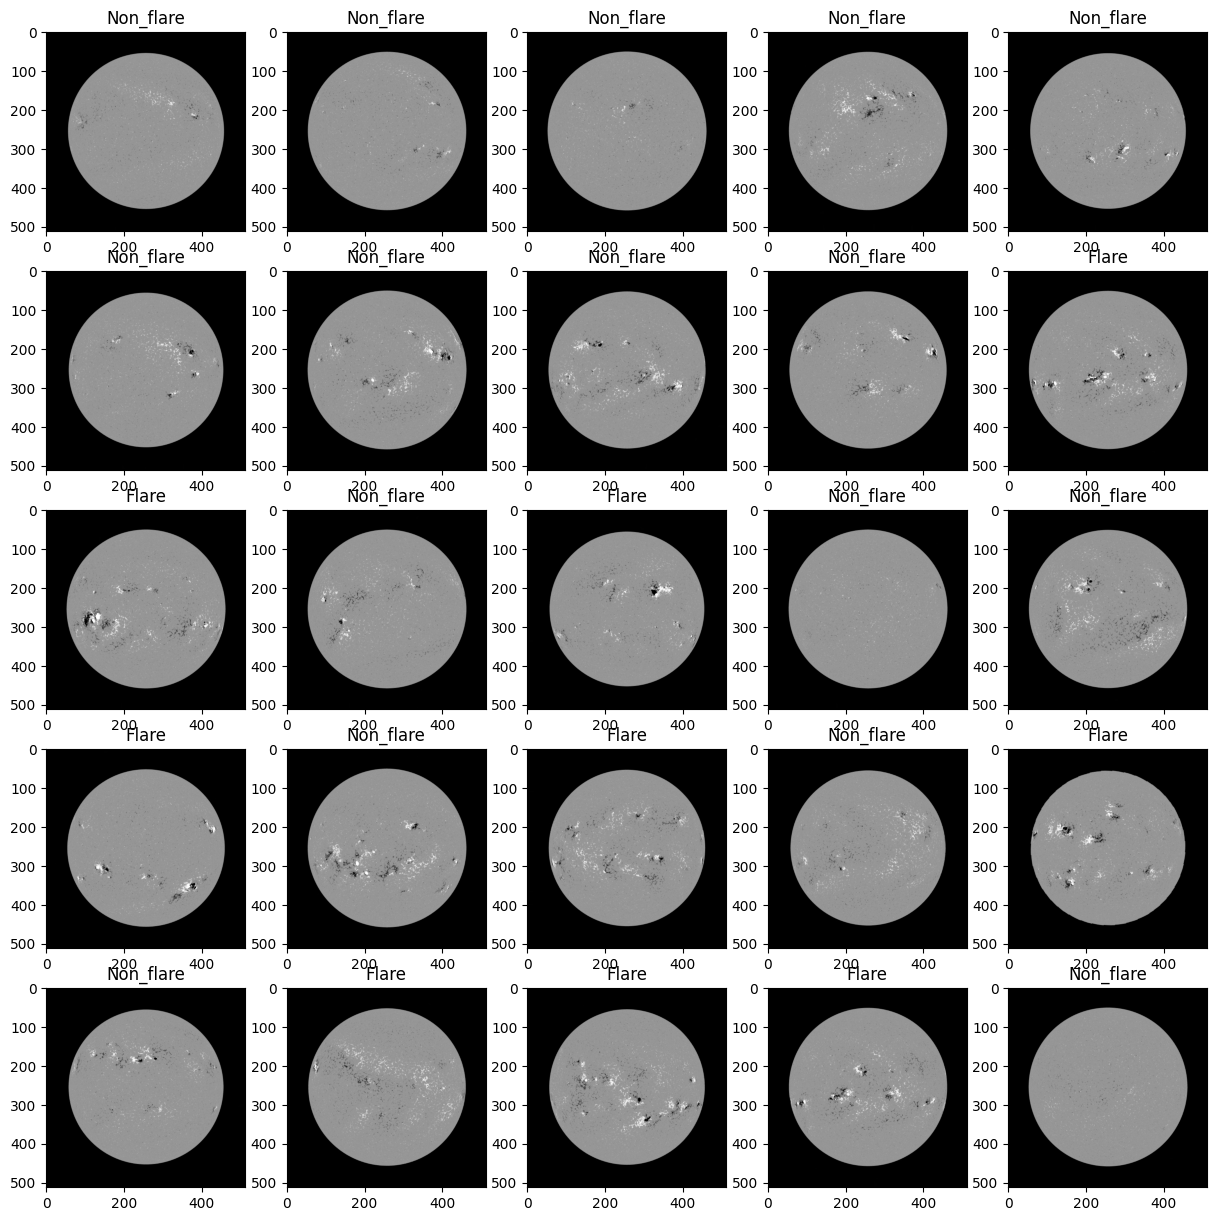

In [7]:
def visualize(data_loader):
    cmap = plt.get_cmap('Greys_r')
    dataiter = iter(data_loader)
    #dataiter.next()
    images, labels = dataiter.next()
    flare_types = {0: 'Non_flare', 1: 'Flare'}
    fig, axis = plt.subplots(5, 5, figsize=(15, 15))
    for i, ax in enumerate(axis.flat):
        with torch.no_grad():
            image, label = images[i], labels[i]
            ax.imshow(image.permute(1,2,0), cmap=cmap, vmin=0, vmax=1) # add image
            ax.set(title = f"{flare_types[label.item()]}")

visualize(train_loader)

In [8]:
# Hyperparameters

in_channel = 1
learning_rate = 0.01
num_epochs = 40


model = Custom_AlexNet(ipt_size=(512, 512), pretrained=True).to(device)

# Loss and optimizer

criterion = nn.NLLLoss(weight=torch.tensor([1., 1.039012003693444])).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.09, patience=4, verbose=True)

In [9]:
def accuracy_score(prediction, target):
    TN, FP, FN, TP = confusion_matrix(target, prediction).ravel()
    print("TP: ", TP, "FP: ", FP, "TN: ", TN, "FN: ", FN)
    #TSS Computation also known as "recall"
    tp_rate = TP / float(TP + FN) if TP > 0 else 0  
    fp_rate = FP / float(FP + TN) if FP > 0 else 0
    TSS = tp_rate - fp_rate
    
    #HSS2 Computation
    N = TN + FP
    P = TP + FN
    HSS = (2 * (TP * TN - FN * FP)) / float((P * (FN + TN) + (TP + FP) * N))

    return TSS, HSS

In [10]:
def sklearn_Compatible_preds_and_targets(model_prediction_list, model_target_list):
    y_pred_list = []
    preds = []
    target_list = []
    tgts = []
    y_pred_list = [a.squeeze().tolist() for a in model_prediction_list]
    preds = [item for sublist in y_pred_list for item in sublist]
    target_list = [a.squeeze().tolist() for a in model_target_list]
    tgts = [item for sublist in target_list for item in sublist]
    return accuracy_score(preds, tgts)

In [11]:
# Training Network
print("Training in Progress..")
train_loss_values = []
val_loss_values = []
train_tss_values = []
val_tss_values = []
train_hss_values = []
val_hss_values = []
train_time = []
val_time = []
learning_rate_values = []
for epoch in range(num_epochs):
    
    #Timer for Training one epoch
    start_train = timeit.default_timer() 
    
    # setting the model to train mode
    model.train()
    train_loss = 0
    train_tss = 0.
    train_hss = 0.
    train_prediction_list = []
    train_target_list = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        train_target_list.append(targets)
        
        # forward prop
        scores = model(data)
        loss = criterion(scores, targets)
        _, predictions = torch.max(scores,1)
        train_prediction_list.append(predictions)
        
        # backward prop
        optimizer.zero_grad()
        loss.backward()
        
        # Adam step
        optimizer.step()
        
        # accumulate the training loss
        #print(loss.item())
        train_loss += loss.item()
        #train_acc+= acc.item()
        
    stop_train = timeit.default_timer()
    print(stop_train-start_train)
    train_time.append(stop_train-start_train)
    # Validation: setting the model to eval mode
    model.eval()
    start_val = timeit.default_timer()
    val_loss = 0.
    val_tss = 0.
    val_hss = 0.
    val_prediction_list = []
    val_target_list = []
    # Turning off gradients for validation
    with torch.no_grad():
        for d, t in val_loader:
            # Get data to cuda if possible
            d = d.to(device=device)
            t = t.to(device=device)
            val_target_list.append(t)
            
            # forward pass
            s = model(d)
            #print("scores", s)
                                   
            # validation batch loss and accuracy
            l = criterion(s, t)
            _, p = torch.max(s,1)
            #print("------------------------------------------------")
            #print(torch.max(s,1))
            #print('final', p)
            val_prediction_list.append(p)
            
            # accumulating the val_loss and accuracy
            val_loss += l.item()
            #val_acc += acc.item()
            del d,t,s,l,p
            torch.cuda.empty_cache()
    scheduler.step(val_loss)
    stop_val = timeit.default_timer()
    val_time.append(stop_val-start_val)
    learning_rate_values.append(optimizer.param_groups[0]['lr'])
    #Epoch Results
    train_loss /= len(train_loader)
    train_loss_values.append(train_loss)
    val_loss /= len(val_loader)
    val_loss_values.append(val_loss)
    train_tss, train_hss = sklearn_Compatible_preds_and_targets(train_prediction_list, train_target_list)
    train_tss_values.append(train_tss)
    train_hss_values.append(train_hss)
    val_tss, val_hss = sklearn_Compatible_preds_and_targets(val_prediction_list, val_target_list)
    scheduler.step(val_tss)
    val_tss_values.append(val_tss)
    val_hss_values.append(val_hss)
    print(f'Epoch: {epoch+1}/{num_epochs}')
    print(f'Training--> loss: {train_loss:.4f}, TSS: {train_tss:.4f}, HSS2: {train_hss:.4f} | Val--> loss: {val_loss:.4f}, TSS: {val_tss:.4f} | HSS2: {val_hss:.4f} ')

Training in Progress..
452.4505546167493
TP:  19012 FP:  7414 TN:  19592 FN:  6980
TP:  1353 FP:  2089 TN:  12380 FN:  900
Epoch: 1/40
Training--> loss: 0.5277, TSS: 0.4569, HSS2: 0.4568 | Val--> loss: 0.3693, TSS: 0.4562 | HSS2: 0.3730 
459.3586119264364
TP:  21479 FP:  3940 TN:  23066 FN:  4513
TP:  978 FP:  1595 TN:  12874 FN:  1275
Epoch: 2/40
Training--> loss: 0.3534, TSS: 0.6805, HSS2: 0.6808 | Val--> loss: 0.3723, TSS: 0.3239 | HSS2: 0.3055 
503.2991068735719
TP:  22581 FP:  2615 TN:  24391 FN:  3411
TP:  1496 FP:  3105 TN:  11364 FN:  757
Epoch: 3/40
Training--> loss: 0.2625, TSS: 0.7719, HSS2: 0.7724 | Val--> loss: 0.4755, TSS: 0.4494 | HSS2: 0.3121 
490.7454821392894
TP:  23250 FP:  2029 TN:  24977 FN:  2742
TP:  2162 FP:  7315 TN:  7154 FN:  91
Epoch: 4/40
Training--> loss: 0.2184, TSS: 0.8194, HSS2: 0.8198 | Val--> loss: 1.3763, TSS: 0.4540 | HSS2: 0.1929 
503.67022978141904
Epoch     9: reducing learning rate of group 0 to 9.0000e-04.
TP:  23526 FP:  1864 TN:  25142 FN:  2

TP:  24453 FP:  1271 TN:  25735 FN:  1539
TP:  1340 FP:  2292 TN:  12177 FN:  913
Epoch: 37/40
Training--> loss: 0.1296, TSS: 0.8937, HSS2: 0.8939 | Val--> loss: 0.4605, TSS: 0.4364 | HSS2: 0.3468 
505.8190598003566
TP:  24466 FP:  1278 TN:  25728 FN:  1526
TP:  1340 FP:  2293 TN:  12176 FN:  913
Epoch: 38/40
Training--> loss: 0.1299, TSS: 0.8940, HSS2: 0.8941 | Val--> loss: 0.4605, TSS: 0.4363 | HSS2: 0.3467 
505.17727456241846
TP:  24498 FP:  1289 TN:  25717 FN:  1494
TP:  1340 FP:  2293 TN:  12176 FN:  913
Epoch: 39/40
Training--> loss: 0.1301, TSS: 0.8948, HSS2: 0.8949 | Val--> loss: 0.4605, TSS: 0.4363 | HSS2: 0.3467 
504.9822137951851
TP:  24492 FP:  1283 TN:  25723 FN:  1500
TP:  1340 FP:  2293 TN:  12176 FN:  913
Epoch: 40/40
Training--> loss: 0.1309, TSS: 0.8948, HSS2: 0.8949 | Val--> loss: 0.4605, TSS: 0.4363 | HSS2: 0.3467 


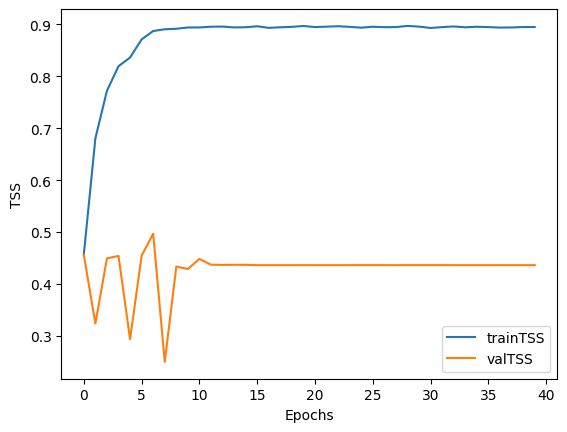

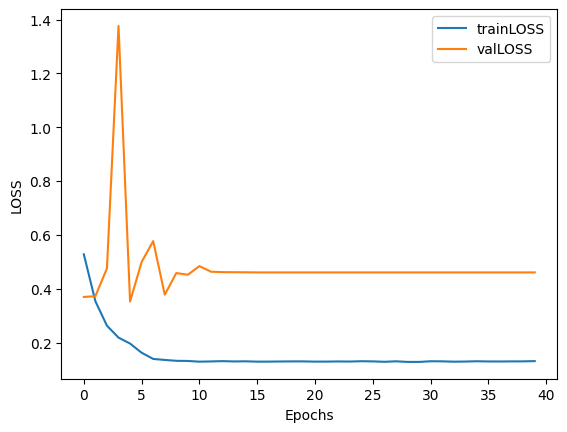

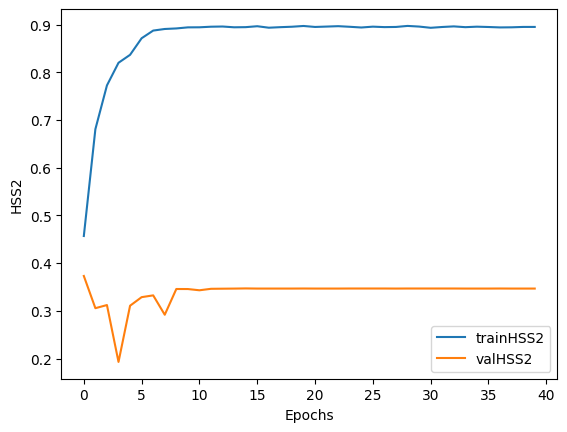

In [12]:
def plot_results(train_values, val_values, plt_type):
    plt.plot(train_values, label='train'+str(plt_type))
    plt.plot(val_values, label='val'+str(plt_type))
    plt.xlabel('Epochs')
    plt.ylabel(plt_type)
    plt.legend()
    plt.show()
    
plot_results(train_tss_values, val_tss_values, 'TSS') 
plot_results(train_loss_values, val_loss_values, 'LOSS')
plot_results(train_hss_values, val_hss_values, 'HSS2')

In [13]:
PATH = 'eighteen.pth'
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
            }, PATH)

results = {
    'train_tss_values':train_tss_values,
    'val_tss_values':val_tss_values,
    'train_hss_values':train_hss_values,
    'val_hss_values':val_hss_values,
    'train_loss_values':train_loss_values,
    'val_loss_values':val_loss_values,
    'learning_rate': learning_rate_values,
    'train_time': train_time,
    'val_time': val_time
}
df = pd.DataFrame(results, columns=['train_tss_values','val_tss_values', 'train_hss_values', 'val_hss_values', 'train_loss_values', 'val_loss_values', 'learning_rate', 'train_time', 'val_time' ])
df.to_csv(r'eighteen.csv', index=False, header=True)